In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from dotenv import load_dotenv
import os
import io

In [19]:
load_dotenv(override=True)  # Isso carrega as variáveis do arquivo .env


s3 = boto3.client('s3',
   aws_access_key_id=os.environ.get("AWS_ACCESS_KEY_ID"),
   aws_secret_access_key=os.environ.get("AWS_SECRET_ACCESS_KEY"),
    aws_session_token=os.environ.get("AWS_SECRET_SESSION_TOKEN"),
   region_name=os.environ.get("AWS_REGION"))

response = s3.get_object(Bucket='meu-bucket-dados-prouni', Key='dadosProuni.csv') # Pega os dados sem baixar o conteudo ainda



In [20]:
conteudo = response['Body'].read()
buffer = io.BytesIO(conteudo) # Simula um arquivo na memória RAM

# Agora pode usar no pandas, com encoding e separador
dataFrame = pd.read_csv(buffer, encoding='windows-1252', sep=';')

dataFrame.head(5)


,ANO_CONCESSAO_BOLSA,CODIGO_EMEC_IES_BOLSA,NOME_IES_BOLSA,MUNICIPIO,CAMPUS,TIPO_BOLSA,MODALIDADE_ENSINO_BOLSA,NOME_CURSO_BOLSA,NOME_TURNO_CURSO_BOLSA,CPF_BENEFICIARIO,SEXO_BENEFICIARIO,RACA_BENEFICIARIO,DATA_NASCIMENTO,BENEFICIARIO_DEFICIENTE_FISICO,REGIAO_BENEFICIARIO,UF_BENEFICIARIO,MUNICIPIO_BENEFICIARIO
0,2020,322,UNIVERSIDADE PAULISTA,IPATINGA,IPATINGA,INTEGRAL,EAD,PEDAGOGIA,CURSO A DISTÂNCIA,991.XXX.XXX-91,F,Parda,11/08/1973,N,SUDESTE,MG,GOVERNADOR VALADARES
1,2020,163,UNIVERSIDADE ESTÁCIO DE SÁ,FORTALEZA,EAD VIA CORPVS - CE,INTEGRAL,EAD,MARKETING,CURSO A DISTÂNCIA,067.XXX.XXX-01,M,Parda,13/05/1987,N,NORDESTE,CE,FORTALEZA
2,2020,17670,FACULDADE DE QUIXERAMOBIM,QUIXERAMOBIM,FACULDADE DE QUIXERAMOBIM - UNIQ,INTEGRAL,PRESENCIAL,FARMÁCIA,NOTURNO,623.XXX.XXX-27,M,Parda,23/07/2001,N,NORDESTE,CE,MOMBACA
3,2020,203,UNIVERSIDADE SÃO JUDAS TADEU,SAO PAULO,PAULISTA,PARCIAL,PRESENCIAL,DIREITO,MATUTINO,089.XXX.XXX-40,F,Branca,04/04/2003,N,NORDESTE,BA,IBITITA
4,2020,203,UNIVERSIDADE SÃO JUDAS TADEU,SAO PAULO,PAULISTA,INTEGRAL,PRESENCIAL,DIREITO,MATUTINO,173.XXX.XXX-09,F,Branca,07/12/1977,N,SUDESTE,SP,SAO PAULO


# Tratar os dados

Eliminar coluna "ANO_CONCESSAO_BOLSA"

In [21]:
dataFrame = dataFrame.drop('ANO_CONCESSAO_BOLSA', axis=1)

dataFrame.head(5)

,CODIGO_EMEC_IES_BOLSA,NOME_IES_BOLSA,MUNICIPIO,CAMPUS,TIPO_BOLSA,MODALIDADE_ENSINO_BOLSA,NOME_CURSO_BOLSA,NOME_TURNO_CURSO_BOLSA,CPF_BENEFICIARIO,SEXO_BENEFICIARIO,RACA_BENEFICIARIO,DATA_NASCIMENTO,BENEFICIARIO_DEFICIENTE_FISICO,REGIAO_BENEFICIARIO,UF_BENEFICIARIO,MUNICIPIO_BENEFICIARIO
0,322,UNIVERSIDADE PAULISTA,IPATINGA,IPATINGA,INTEGRAL,EAD,PEDAGOGIA,CURSO A DISTÂNCIA,991.XXX.XXX-91,F,Parda,11/08/1973,N,SUDESTE,MG,GOVERNADOR VALADARES
1,163,UNIVERSIDADE ESTÁCIO DE SÁ,FORTALEZA,EAD VIA CORPVS - CE,INTEGRAL,EAD,MARKETING,CURSO A DISTÂNCIA,067.XXX.XXX-01,M,Parda,13/05/1987,N,NORDESTE,CE,FORTALEZA
2,17670,FACULDADE DE QUIXERAMOBIM,QUIXERAMOBIM,FACULDADE DE QUIXERAMOBIM - UNIQ,INTEGRAL,PRESENCIAL,FARMÁCIA,NOTURNO,623.XXX.XXX-27,M,Parda,23/07/2001,N,NORDESTE,CE,MOMBACA
3,203,UNIVERSIDADE SÃO JUDAS TADEU,SAO PAULO,PAULISTA,PARCIAL,PRESENCIAL,DIREITO,MATUTINO,089.XXX.XXX-40,F,Branca,04/04/2003,N,NORDESTE,BA,IBITITA
4,203,UNIVERSIDADE SÃO JUDAS TADEU,SAO PAULO,PAULISTA,INTEGRAL,PRESENCIAL,DIREITO,MATUTINO,173.XXX.XXX-09,F,Branca,07/12/1977,N,SUDESTE,SP,SAO PAULO


Trocando valores nulos da coluna de curso pela moda

In [22]:
moda = dataFrame["NOME_CURSO_BOLSA"].describe()['top']

dataFrame['NOME_CURSO_BOLSA'] = dataFrame["NOME_CURSO_BOLSA"].fillna(moda)

dataFrame['NOME_CURSO_BOLSA'].isnull().value_counts()

NOME_CURSO_BOLSA
False    166830
Name: count, dtype: int64

# Analise

#### FAIXA ETARIA DOS ESTUDANTES COM PROUNI

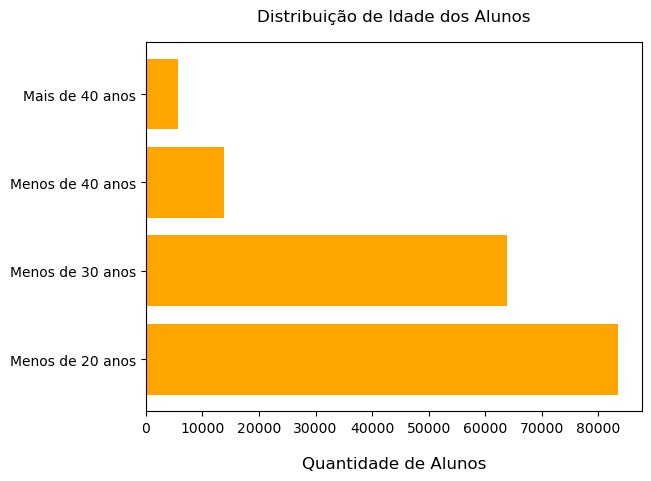

In [23]:

# Funçao de manipulação de STRING
def fix_data(data):
    nova_data = data[3:5] + '/' + data[0:2] + '/' + data[6:] ## Apenas troca os dados de lugar
    return nova_data

dataFrame['DATA_NASCIMENTO'] = dataFrame['DATA_NASCIMENTO'].apply(fix_data)

# Função de conversão
dataFrame['DATA_NASCIMENTO'] = pd.to_datetime(dataFrame['DATA_NASCIMENTO'])

# Função de condicional
def decada(linha):
    ano = linha['DATA_NASCIMENTO'].year # Função de data
    if ano >= 2000:
        return 'Menos de 20 anos'
    elif ano >= 1990:
        return 'Menos de 30 anos'
    elif ano >= 1980:
        return 'Menos de 40 anos'
    else:
        return 'Mais de 40 anos'
    
dataFrame['IDADE'] = dataFrame.apply(decada,axis=1)

dataFrame['IDADE'].value_counts() # Testando para identificar se a função funcionou

plt.barh(dataFrame['IDADE'].value_counts().index, dataFrame['IDADE'].value_counts(),color='orange')
plt.title('Distribuição de Idade dos Alunos',pad=15)
plt.xlabel('Quantidade de Alunos',labelpad=15,fontsize=12)

plt.savefig('analise1.png', dpi=300, bbox_inches='tight') # Salva a imagem


#### QUANTOS ESTUDANTES ESTÃO RECEBENDO BOLSA INTEGRAL DE MEDICINA QUE NÃO SÃO BRANCOS

Quantidade de alunos que não são brancos: 1108
Quantidade de alunos que são brancos: 1061


/tmp/ipykernel_168869/2496669646.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nao_sao = dataFrame[(dataFrame['TIPO_BOLSA'] == 'INTEGRAL') & (dataFrame['NOME_CURSO_BOLSA'] == 'MEDICINA') & ~(dataFrame['RACA_BENEFICIARIO'] == 'Branca')].count()[0]
/tmp/ipykernel_168869/2496669646.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sao = dataFrame[(dataFrame['TIPO_BOLSA'] == 'INTEGRAL') & (dataFrame['NOME_CURSO_BOLSA'] == 'MEDICINA') & (dataFrame['RACA_BENEFICIARIO'] == 'Branca')].count()[0]


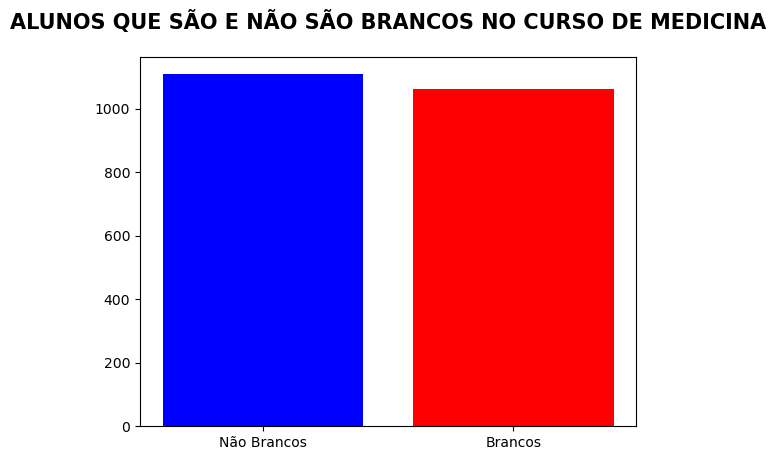

In [24]:
# Função com mais de filtro com mais de 2 operadores lógicos
nao_sao = dataFrame[(dataFrame['TIPO_BOLSA'] == 'INTEGRAL') & (dataFrame['NOME_CURSO_BOLSA'] == 'MEDICINA') & ~(dataFrame['RACA_BENEFICIARIO'] == 'Branca')].count()[0] 

sao = dataFrame[(dataFrame['TIPO_BOLSA'] == 'INTEGRAL') & (dataFrame['NOME_CURSO_BOLSA'] == 'MEDICINA') & (dataFrame['RACA_BENEFICIARIO'] == 'Branca')].count()[0]

print(f'Quantidade de alunos que não são brancos: {nao_sao}')
print(f'Quantidade de alunos que são brancos: {sao}')

plt.title('ALUNOS QUE SÃO E NÃO SÃO BRANCOS NO CURSO DE MEDICINA',fontsize=15, fontweight='bold',pad=20)

plt.bar(['Não Brancos','Brancos'],[nao_sao,sao],color=['blue','red'])

plt.savefig('analise2.png', dpi=300, bbox_inches='tight') # Salva a imagem

#### OS TOP 3 CURSOS COM MAIS ESTUDANTES UTILIZANDO O PROUNI, POR REGIÃO.

In [25]:
# O head quando se trata de groupby, pega os n elementos de cada grupo.
ex3Result = dataFrame.value_counts(['REGIAO_BENEFICIARIO', 'NOME_CURSO_BOLSA']).reset_index(name='TOTAL').groupby('REGIAO_BENEFICIARIO').head(3)

ex3Result.to_csv('analise3.csv', index=False) # Salva o resultado em CSV

ex3Result

,REGIAO_BENEFICIARIO,NOME_CURSO_BOLSA,TOTAL
0,SUDESTE,ADMINISTRAÇÃO,6252
1,SUDESTE,DIREITO,5804
2,SUDESTE,PEDAGOGIA,5287
3,NORDESTE,DIREITO,4011
4,NORDESTE,ADMINISTRAÇÃO,3396
6,NORDESTE,PEDAGOGIA,3098
11,SUL,ADMINISTRAÇÃO,2698
13,SUL,DIREITO,2163
14,SUL,PEDAGOGIA,2148
17,NORTE,PEDAGOGIA,1993


# EXPORTANDO NOVO CSV

In [26]:
# Salva o DataFrame nesse "arquivo em memória"
dataFrame.to_csv('resultado.csv', index=False, sep=';')

try:
    s3.upload_file(
        Filename='resultado.csv',         # Caminho do seu arquivo local
        Bucket='meu-bucket-dados-prouni',                     # Nome do bucket no S3
        Key='resultado.csv',           # Nome do arquivo no S3
    )

    s3.upload_file(
        Filename='analise1.png',         # Caminho do seu arquivo local
        Bucket='meu-bucket-dados-prouni',                     # Nome do bucket no S3
        Key='analises/analise1.png',           # Nome do arquivo no S3
    )

    s3.upload_file(
        Filename='analise2.png',         # Caminho do seu arquivo local
        Bucket='meu-bucket-dados-prouni',                     # Nome do bucket no S3
        Key='analises/analise2.png',           # Nome do arquivo no S3
    )

    s3.upload_file(
        Filename='analise3.csv',         # Caminho do seu arquivo local
        Bucket='meu-bucket-dados-prouni',                     # Nome do bucket no S3
        Key='analises/analise3.csv',           # Nome do arquivo no S3
    )
    print("Arquivos upados com sucesso!")
except Exception as e:
    print("Erro ao fazer upload dos arquivos: " + e)


Arquivos upados com sucesso!
